2
2
0
82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1


82.1




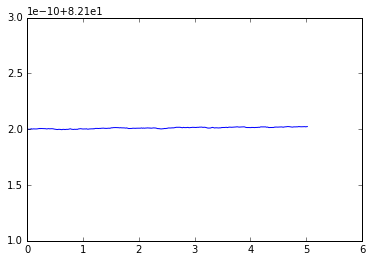

Simulation: dt=0.010000, tf=5.000000, runtime=0.137283 s


In [17]:
### normal stance phase system

import trep
from trep import tx,ty,tz,rx,ry,rz
import time
import trep.visual as visual
import matplotlib.pyplot as plt
%matplotlib inline

dt = 0.01
tf = 5.0

spring_length = 2.5

def simulate_system(system):
    # Now we'll extract the current configuration into a tuple to use as
    # initial conditions for a variational integrator.
    q0 = system.q

    # Create and initialize the variational integrator
    mvi = trep.MidpointVI(system)
    mvi.initialize_from_configs(0.0, q0, dt, q0)
    
#     print system.nQ
#     print system.nQd
#     print system.nQk
    
    # calculate Hamiltonian
    p = [system.L_ddq(a) for a in system.configs]
    qdot = system.dq
        
    H1 = np.dot(p, qdot) - system.L()
    H = [H1]

    # This is our simulation loop.  We save the results in two lists.
    q = [mvi.q2]
    t = [mvi.t2]
    while mvi.t1 < tf:
        mvi.step(mvi.t2+dt)
        q.append(mvi.q2)
        t.append(mvi.t2)
        
        # calculate Hamiltonian
        p = [system.L_ddq(a) for a in system.configs]
        qdot = system.dq

        H1 = np.dot(p, qdot) - system.L()

        print H1
        print '\n'
        
        H.append(H1)

    return (t,q,H)


# system for stance
stance = trep.System()
stance.import_frames([
    tz(0,name='foot'), [
        rx('theta0'), [
            tz('l',mass=1,name='hip')
        ]
    ]
])

trep.potentials.LinearSpring(stance,'foot','hip',k=500,x0=spring_length)
trep.forces.LinearDamper(stance,'foot','hip',c=0.0)
trep.potentials.Gravity(stance,(0,0,-9.8))

stance.q = [0.,2.]

# Simulate
start = time.clock()
(t, q, H) = simulate_system(stance)
finish = time.clock()

# plot Hamiltonian
plt.plot(t,H)
plt.show()

# Display
print "Simulation: dt=%f, tf=%f, runtime=%f s" % (dt, tf, finish-start)
# visual.visualize_3d([ visual.VisualItem3D(stance, t, q) ])

In [19]:
# simulate a SLIP model hopping vertically in trep

import trep
from trep import tx,ty,tz,rx,ry,rz
import time
import trep.visual as visual
import numpy as np
from copy import deepcopy

dt = 0.0001
tf = 30.0

spring_length = 2.0
eps = 0.0001

def simulate_SLIP(stance_system, flight_system):
    # Now we'll extract the current configuration into a tuple to use as
    # initial conditions for a variational integrator.
    q0 = [0.0,1.7]
    q1 = [0.0,1.7]
    
    tcur = 0.0
    
    # start in stance phase
    # Create and initialize the variational integrator
    mvi = trep.MidpointVI(stance)
    mvi.initialize_from_configs(tcur, q0, dt, q1)

    # save the results in three lists
    qstance = [mvi.q2] # [theta, spring_length]
    qflight = [np.zeros(2)] # [z, theta]
    t = [mvi.t2]
    sys = [0] # stance = 0, flight = 1
    
    # calculate Hamiltonian
    p = [stance.L_ddq(a) for a in stance.configs]
    qdot = stance.dq
        
    H1 = np.dot(p, qdot) - stance.L()
    H = [H1]
    
    while tcur < tf:
        
        # during simulation, check for two phases:
        # 1. stance
        # 2. flight
        
        # simulate stance phase
        while qstance[-1][1] < (spring_length+eps):
            # simulate stance system forward
            mvi.step(mvi.t2+dt)
            qstance.append(mvi.q2)
            qflight.append(np.zeros(2))
            t.append(tcur+mvi.t2)
#             print "Time: %f; Spring length: %f" % (t[-1], qstance[-1][1])
            sys.append(0)
    
            # calculate Hamiltonian
            p = [stance.L_ddq(a) for a in stance.configs]
            qdot = stance.dq
            H1 = np.dot(p, qdot) - stance.L()
            H.append(H1)
            
    
            if t[-1]>tf:
                break
            
        if t[-1]>tf:
            break
        
        tcur = t[-1]
        
        # enter flight phase
        q0 = [(qstance[-2][1]-spring_length),qstance[-2][0]] #,qstance[-2][1]]
        q1 = [(qstance[-1][1]-spring_length),qstance[-1][0]] #,qstance[-1][1]]
        mvi = trep.MidpointVI(flight)
        mvi.initialize_from_configs(0.0, q0, dt, q1)
        
        # save new results
        qflight.append(mvi.q2)
        qstance.append([0.0, spring_length])
        t.append(tcur+mvi.t2)
        sys.append(1)
        
        # calculate Hamiltonian
        p = [flight.L_ddq(a) for a in flight.configs]
        qdot = flight.dq
        H1 = np.dot(p, qdot) - flight.L()
        H.append(H1)
        
        # simulate flight phase
        while qflight[-1][0] > (-eps):
            # simulate system forward
            mvi.step(mvi.t2+dt)
            qflight.append(mvi.q2)
            qstance.append([0.0, spring_length])
            t.append(tcur+mvi.t2)
            
            # calculate Hamiltonian
            p = [flight.L_ddq(a) for a in flight.configs]
            qdot = flight.dq
            H1 = np.dot(p, qdot) - flight.L()
            H.append(H1)
            
#             print "Time: %0.4f; Foot height: %0.4f" % (t[-1], qflight[-1][0])
            sys.append(1)
            if t[-1]>tf:
                break
            
        if t[-1]>tf:
            break
            
        tcur = t[-1]
        
        # set up for stance phase again
        q0 = [qflight[-2][1],spring_length]
        q1 = [qflight[-1][1],(qflight[-1][0]+spring_length)]
        mvi = trep.MidpointVI(stance)
        mvi.initialize_from_configs(0.0, q0, dt, q1)
        
        # save new results
        qstance.append(mvi.q2)
        qflight.append(np.zeros(2))
        t.append(tcur+mvi.t2)
        sys.append(0)
        
        # calculate Hamiltonian
        p = [stance.L_ddq(a) for a in stance.configs]
        qdot = stance.dq
        H1 = np.dot(p, qdot) - stance.L()
        H.append(H1)
        

    return (t,qstance,qflight,sys,H)

# system for flight 
flight = trep.System()
flight.import_frames([
    tz('z',name='foot'), [
        rx('theta0'), [
            tz(spring_length,mass=2,name='hip')
        ]
    ]
])

# trep.potentials.LinearSpring(flight,'foot','hip',k=200,x0=spring_length)
# trep.forces.LinearDamper(flight,'foot','hip',c=1.0)
trep.potentials.Gravity(flight,(0,0,-9.8))

# system for stance
stance = trep.System()
stance.import_frames([
    tz(0,name='foot'), [
        rx('theta0'), [
            tz('l',mass=2,name='hip')
        ]
    ]
])

trep.potentials.LinearSpring(stance,'foot','hip',k=500,x0=spring_length)
trep.forces.LinearDamper(stance,'foot','hip',c=0.0)
trep.potentials.Gravity(stance,(0,0,-9.8))

# Simulate
# system.satisfy_constraints()
start = time.clock()
(t, qstance, qflight, sys, H) = simulate_SLIP(stance, flight)
finish = time.clock()

# Display
print "Simulation: dt=%f, tf=%f, runtime=%f s" % (dt, tf, finish-start)

Simulation: dt=0.000100, tf=30.000000, runtime=6.512758 s


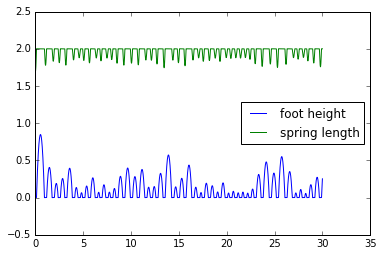

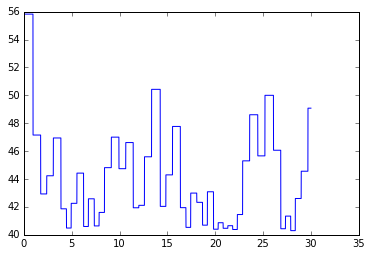

0

In [20]:
# visualize the hopping SLIP model
import matplotlib.pyplot as plt
%matplotlib inline

# merge qstance and qflight
# qstance_mod = np.hstack((np.zeros((len(t),1)),np.asarray(qstance)))
qstance_mod = np.asarray(qstance)
qflight_mod = np.asarray(qflight)
# qflight_mod = np.hstack((np.asarray(qflight),np.zeros((len(t),1))))
# stance_idx = np.nonzero(qstance_mod)
# print len(qstance)
# print len(t)
# print t
np.set_printoptions(threshold=np.nan)

# print len(t)
# print np.shape(qflight_mod[:,0])
# print np.shape(qstance_mod)
# print np.shape(qflight_mod)

q = np.hstack((np.reshape(qflight_mod[:,0], (len(t),1)),qstance_mod))

# print q

# full system with all states
full = trep.System()
full.import_frames([
    tz('z',name='foot'), [
        rx('theta0'), [
            tz('l',mass=2,name='hip')
        ]
    ]
])

trep.potentials.LinearSpring(full,'foot','hip',k=200,x0=spring_length)
trep.forces.LinearDamper(full,'foot','hip',c=0.0)
trep.potentials.Gravity(full,(0,0,-9.8))

plt.plot(t, q[:,0],label='foot height')
plt.plot(t, q[:,2],label='spring length')
plt.legend(loc='best')
plt.show()

plt.plot(t, H)
plt.show()

visual.visualize_3d([ visual.VisualItem3D(full, t, q) ])